In [28]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [29]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [30]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=40)
  return embed.embed_file('./animation.gif')

In [31]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()

categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [32]:
import random

# Shuffle the list of videos
random.shuffle(ucf_videos)

# Calculate the size of each class
class_size = len(ucf_videos) // 3

# Assign videos to classes
class_1 = ucf_videos[:class_size]
class_2 = ucf_videos[class_size:2*class_size]
class_3 = ucf_videos[2*class_size:]

In [33]:
print("Class 1 size:", len(class_1))
print("Class 2 size:", len(class_2))
print("Class 3 size:", len(class_3))

Class 1 size: 4440
Class 2 size: 4440
Class 3 size: 4440


In [34]:
import pandas as pd

# Create a list of tuples containing video names and their corresponding class labels
video_labels = [(video, 'Class 1') for video in class_1] + [(video, 'Class 2') for video in class_2] + [(video, 'Class 3') for video in class_3]

# Create a DataFrame from the list of tuples
df = pd.DataFrame(video_labels, columns=['Video Name', 'Label'])

# Display the DataFrame

# Data Preprocessing

In [35]:
import cv2
import numpy as np

def extract_frames(video_path, max_frames=60, resize=None):
    # Initialize an empty list to store frames
    frames = []
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Resize the frame if resize argument is provided
            if resize is not None:
                frame = cv2.resize(frame, resize)
            # Convert the frame to RGB (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Normalize pixel values to [0, 1]
            frame = frame / 255.0
            # Append the frame to the list
            frames.append(frame)
            # Increment frame count
            frame_count += 1
            # Break the loop if max_frames is reached
            if frame_count == max_frames:
                break
    finally:
        # Release the video capture object
        cap.release()
    return frames







In [36]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Initialize InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess an image for the InceptionV3 model
def preprocess_image(img):
    img_array = image.img_to_array(img)
    img_array = crop_center_square(img_array)  # Crop center square
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to extract features from an image using InceptionV3
def extract_features_from_image(img):
    img_array = preprocess_image(img)
    features = base_model.predict(img_array)
    return features


In [37]:
# Function to extract features for all frames per video and aggregate them
def extract_video_features(video_frames):
    # Initialize a list to store features for each frame
    frame_features = []

    # Iterate through each frame and extract features
    for frame in video_frames:
        # Extract features using the feature extractor
        frame_feature = extract_features_from_image(frame)

        # Append the features to the list
        frame_features.append(frame_feature)

    # Aggregate features from all frames to represent the entire video
    video_features = np.mean(frame_features, axis=0)

    return video_features

In [38]:
video_paths = df['Video Name'].tolist()
labels = df['Label'].tolist()

In [39]:
len(video_paths)

13320

In [40]:
print(labels)

['Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1'

In [41]:
from sklearn.model_selection import train_test_split
# Sample 300 videos randomly from your dataset
random_sample_indices = np.random.choice(len(video_paths), size=300, replace=False)
sampled_video_paths = [video_paths[i] for i in random_sample_indices]
sampled_labels = [labels[i] for i in random_sample_indices]

# Initialize lists to store video features and labels
train_features, val_features, test_features = [], [], []
train_labels, val_labels, test_labels = [], [], []

# Split the sampled dataset into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(sampled_video_paths, sampled_labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Extract features for training videos
for video in train_paths:
    video_path = fetch_ucf_video(video)
    video_frames = extract_frames(video_path)
    video_features = extract_video_features(video_frames)
    train_features.append(video_features)

# Extract features for validation videos
for video in val_paths:
    video_path = fetch_ucf_video(video)
    video_frames = extract_frames(video_path)
    video_features = extract_video_features(video_frames)
    val_features.append(video_features)

# Extract features for testing videos
for video in test_paths:
    video_path = fetch_ucf_video(video)
    video_frames = extract_frames(video_path)
    video_features = extract_video_features(video_frames)
    test_features.append(video_features)

# Convert lists to numpy arrays
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

print("Shape of train video features:", train_features.shape)
print("Shape of train video labels:", len(train_labels))
print("Shape of val video features:", val_features.shape)
print("Shape of val video labels:", len(val_labels))
print("Shape of test video features:", test_features.shape)
print("Shape of test video labels:", len(test_labels))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 189ms/step
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skiing_g13_c02.avi => /tmp/tmp0bh3kiug/v_Skiing_g13_c02.avi
1/1 [==============================] - 0s 303ms/step
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_FrisbeeCatch_g15_c03.avi => /tmp/tmp0bh3kiug/v_FrisbeeCatch_g15_c03.avi
1/1 [==============================] - 0s 184ms/step
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BodyWeightSquats_g12_c02.avi => /tmp/tmp0bh3kiug/v_BodyWeightSquats_g12_c02.avi
1/1 [==============================] - 0s 174ms/step
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketBowling_g22_c05.avi => /tmp/tmp0bh3kiug/v_CricketBowling_g22_c05.avi
1/1 [==============================] - 0s 182ms/step
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_WalkingWithDog_g16_c01.avi => /tmp/tmp0bh3kiug/v_WalkingWithDog_g16_c01.avi
1/1 [====================

In [42]:
# Reshape the labels to match the number of samples in the features
train_labels = np.expand_dims(train_labels, axis=1)
val_labels = np.expand_dims(val_labels, axis=1)
test_labels = np.expand_dims(test_labels, axis=1)


In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert integer labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = tf.keras.utils.to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input  # Import Input layer here

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define the model
rnn_model = Sequential()
rnn_model.add(Input(shape=(1, 2048), name="Input"))  # Adjust the input shape to match your features
rnn_model.add(LSTM(16, return_sequences=True, name="LSTM-1"))
rnn_model.add(LSTM(8, name="LSTM-2"))
rnn_model.add(Dense(8, activation="relu", name="Dense-1"))
rnn_model.add(Dense(len(label_encoder.classes_), activation="softmax", name="Output"))

# Compile the model
rnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train the model
history = rnn_model.fit(train_features, train_labels_encoded, validation_data=(val_features, val_labels_encoded), epochs=35)

# Evaluate the model
test_loss, test_acc = rnn_model.evaluate(test_features, test_labels_encoded)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/35
6/6 [==============================] - 7s 232ms/step - loss: 1.0985 - accuracy: 0.3556 - val_loss: 1.0981 - val_accuracy: 0.4000
Epoch 2/35
6/6 [==============================] - 0s 19ms/step - loss: 1.0969 - accuracy: 0.4444 - val_loss: 1.0960 - val_accuracy: 0.4000
Epoch 3/35
6/6 [==============================] - 0s 16ms/step - loss: 1.0964 - accuracy: 0.4056 - val_loss: 1.0937 - val_accuracy: 0.4167
Epoch 4/35
6/6 [==============================] - 0s 17ms/step - loss: 1.0944 - accuracy: 0.4444 - val_loss: 1.0944 - val_accuracy: 0.4000
Epoch 5/35
6/6 [==============================] - 0s 16ms/step - loss: 1.0936 - accuracy: 0.4444 - val_loss: 1.0943 - val_accuracy: 0.4000
Epoch 6/35
6/6 [==============================] - 0s 16ms/step - loss: 1.0922 - accuracy: 0.4444 - val_loss: 1.0919 - val_accuracy: 0.4000
Epoch 7/35
6/6 [==============================] - 0s 16ms/step - loss: 1.0906 - accuracy: 0.4444 - val_loss: 1.0903 - val_accuracy: 0.4000
Epoch 8/35
6/6 [==========

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict labels for the test set
predictions = rnn_model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels_encoded, predicted_labels)
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


2/2 [==============================] - 1s 9ms/step
Accuracy: 0.4166666666666667
Precision: 0.3954761904761905
Recall: 0.4166666666666667
F1-score: 0.3942760942760942


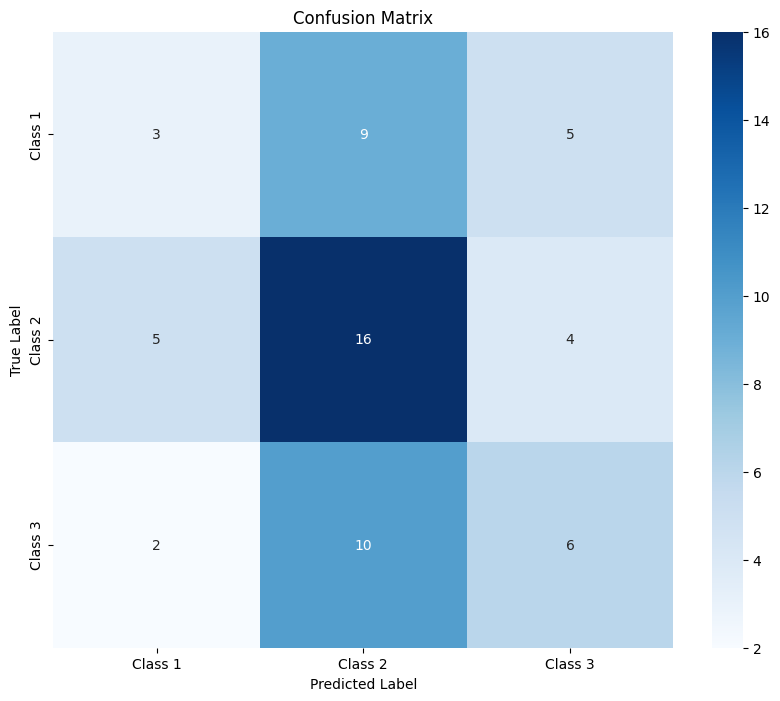

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
